###   Background of code


We attempt to discover or mine information from the email dataset in different ways / visualization methods.

This jupyter notebook contains static visuals (refer to the other ipynb file for interactive visuals). Due to differences in the codes used to display interactive visuals vis-a-vis static visuals, I had to re-code this in a different way, especially for the **networkx graphs**.

###   Basic configuration steps

### We install some packages
Packages for basic processing, data manipulation, visualisation and graphing of network

In [1]:
# - import basic python packages
import warnings
import tkinter  # to show plot in Pycharm

warnings.simplefilter(action='ignore', category=FutureWarning)

# - import packages for data manipulations
import numpy as np
import pandas as pd
from datetime import date, datetime
from collections import Counter
import random

# - import packages for visualisation
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"
# pio.renderers.default = "browser"


from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

### Additionally, we install packages for NLP

For the installation of "en_core_web_sm", we use the following command in terminal "pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.1.0/en_core_web_sm-3.1.0.tar.gz". The file was then downloaded to this folder: "/home/kelvinhwee/.cache/pip/wheels/62/79/40/648305f0a2cd1fdab236bd6764ba467437c5fae2a925768153"
(look out for the installation completion message in the terminal).

Lastly, we copied the zipped file, and extracted the "en_core_web_sm-3.1.0" folder (containing the "config.cfg" file) into the working directory

In [2]:
import re
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from nltk.tokenize import sent_tokenize
import nltk

nltk.download('punkt') # uncomment this if you run into punkt download issues

[nltk_data] Downloading package punkt to /home/kelvinhwee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# - we load the spacy trained pipelines (for English); this is an English pipeline optimized for CPU
nlp = spacy.load('en_core_web_sm-3.1.0')

# - initialise the spacy Matcher with a vocab; matcher must always share the same vocab with the documents it operate on
matcher = Matcher(nlp.vocab)

In [4]:
# - other configurations
pd.set_option("display.max_column", None)
source_filepath = '/home/kelvinhwee/PycharmProjects/sourceFiles'

# - packages created
from utils import extract_domain, reformat_email_func
from utils import one_to_one_mapping
from utils import get_relation, get_entities

### Read CSV data file

The Enron email dataset contains approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse.

This is the May 7, 2015 Version of dataset, as published at https://www.cs.cmu.edu/~./enron/. we note that there are only two columes, "file" and "message".

For this exercise, we have used a smaller sample set which we derived from the full data (commands to load full data have been commented out).

In [5]:
# # - read in the CSV data
# emails_df = pd.read_csv(source_filepath + '/emails.csv')
#
# - read in the sample CSV data
# import random
# sample_vals = random.sample(list(range(emails_df.shape[0])), 5000)
# emails_df.loc[sample_vals].to_csv(source_filepath + '/sample_emails.csv')

emails_df = pd.read_csv(source_filepath + '/sample_emails.csv')
print("We look at a sample of the data: \n", emails_df.head(10))

We look at a sample of the data: 
    Unnamed: 0                              file  \
0      237243          kean-s/attachments/1757.   
1       63803    dasovich-j/all_documents/4101.   
2      320451                 mann-k/sent/3197.   
3      367550             quigley-d/fin_desk/6.   
4       83252              dasovich-j/sent/700.   
5      476834      taylor-m/all_documents/7964.   
6      465472       symes-k/all_documents/3742.   
7      112944       fischer-m/deleted_items/17.   
8      107663  farmer-d/discussion_threads/553.   
9      114674           forney-j/sent_items/95.   

                                             message  
0  Message-ID: <27407479.1075851045148.JavaMail.e...  
1  Message-ID: <301250.1075843054571.JavaMail.eva...  
2  Message-ID: <15348104.1075845996347.JavaMail.e...  
3  Message-ID: <9943936.1075841449972.JavaMail.ev...  
4  Message-ID: <32384912.1075843200467.JavaMail.e...  
5  Message-ID: <23924850.1075860197196.JavaMail.e...  
6  Message-ID: <13

### Feature engineering
Extract critical data points from email messages. For a start, we try to replace some characters.

In [6]:
for i in range(emails_df.shape[0]):
    temp_text = emails_df["message"][i]
    new_text = temp_text.replace("\n ", " ")  # some "\n " in subject; , clean them to space character
    # new_text = new_text.replace("\n\n", "\n")  # dropped this; the one after "filename" always has double "\n"
    new_text = new_text.replace("Re: ", "")  # some "Re: " in subject; , clean them to blanks
    new_text = new_text.replace("Fw: ", "")  # some "Fw: " in subject; , clean them to blanks
    new_text = new_text.replace("\n\t", "")  # very long recipient list has "\n\t"; clean them to blanks
    new_text = new_text.replace(" : ", "")  # some ":" in subject; , clean them to blanks
    new_text = new_text.replace("[IMAGE]", "")  # some "[IMAGE]" tags; , clean them to blanks
    emails_df.loc[i, "message"] = new_text

Next we try to collate the list of fields present in the email message and then we create a dictionary object to do some information extraction for processing later on.

In [7]:
# - we collate the list of "keys"
keys_list = ['Message-ID', 'Date', 'From', 'To', 'Subject', 'Cc', 'Mime-Version', 'Content-Type',
             'Content-Transfer-Encoding', 'Bcc', 'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin',
             'X-FileName']

fields_list = keys_list + ["Sent"]  # to add in additional fields to clean (for RegEx later)
fields_list_plus = fields_list + [i.lower() for i in fields_list] \
                   + [i.upper() for i in fields_list]  # include variations of lower and upper case

# - create dictionary (using dictionary comprehension) to do "conversion" later on (you will see)
keys_dict = {i: [k, len(k)] for i, k in enumerate(keys_list)}

We try to perform a batch-wise extraction of the email contents based on the placeholders e.g. "To", "From", "Subject". We collate the list of regex logic first.

In [8]:
# regex logic
clean_html_tags = re.compile("<[/]*.*?>|&nbsp;")
clean_multi_space = re.compile("[\s]{2,}")
clean_field_headers = re.compile('|'.join([item + ":" for item in fields_list_plus]))
clean_emails = re.compile("[\w._]+@[\w.]+")
clean_fwds = re.compile("[-_]{2,}.*?[-_]{2,}|FW:|Fwd:|RE:")  # cleans "Forwarded by" in between long dashes and others
clean_unintended_sends = re.compile("[-_*]{2,}.*?[-_*]{2,}")
clean_dashes = re.compile("[-]{2,}")
clean_transmission_warn = re.compile(r"The information.*?any computer.")  # cleans warning texts
clean_datetime = re.compile("[\d]{1,2}/[\d]{1,2}/[\d]{4}\s+[\d]{1,2}:[\d]{1,2}[:\d]*\s+[AMPM]+")  # for format DD/MM/YYYY XX:XX:XX AM/PM
clean_multi_symbols = re.compile("[>,(\"\'\\!.\[\]-]+\s?[>,(\"\'\\!.\[\]-]+")  # e.g. "> >", ", , ", ", ("
clean_addr_code = re.compile("[, ]*[A-Z]{2}\s+[\d]{5}")  # cleans ", TX 77082"
clean_phone_fax = re.compile("[\d]*[-]*[\d]{3}-[\d]{3}-[\d]{4}[\s]*[(]*\w*[)]*")  # "713-853-3989 (Phone)", "713-646-3393(Fax", "1-888-334-4204"
clean_phone_ctrycode = re.compile("\([\d]{3}\)[\s]*[\d]{3}-[\d]{4}")  # (281) 558-9198, (713) 670-2457
clean_link = re.compile(r"[http]*[https]*[:/]*/?[\w]+[.][\w]+.*[.][\w]+")  # e.g. http://explorer.msn.com, https://explorer.msn.com.net"
clean_email_codes = re.compile("[=][\d]+")  # clear email codes "=19", "=20"
clean_very_long_text = re.compile("[\w+]{20,}")
# Other things to clean: Staff Meeting - Mt. Ranier 5/30/2001 Time: 1:00 PM - 3:00 PM (Central Standard Time)

We now perform the batch-wise extraction of email contents using the regex logic compiled above.

In [9]:
list_of_dict = []
for i in range(emails_df.shape[0]):  # i=4

    email_dict = {}  # empty dictionary to store the key-value pair
    temp_str = emails_df["message"][i].split("\n")  # assign string to variable; so can insert values to specific place

    # this step uses the above created dictionary to "impute" keys if there are missing key values, e.g. "To", "Cc"
    for pos in range(len(keys_list)):
        if temp_str[pos][0:len(keys_dict[pos][0])] != keys_dict[pos][0]:
            temp_str.insert(pos, str(keys_dict[pos][0]) + ': ')

    # this step performs the split and extract the key-value pair for the standard known field headers
    for j in range(0, 17):
        key = temp_str[j].split(":")[0]
        val = ':'.join(temp_str[j].split(":")[1:]).strip()
        email_dict[key] = val

    # this step saves the body of the text; we apply some regex logic
    text_body = temp_str[17:]
    text_body = " ".join([text for text in text_body]).strip()  # joins back all elements into a single string

    # apply regex logic
    text_body = re.sub(clean_field_headers, "", text_body)
    text_body = re.sub(clean_html_tags, "", text_body)
    text_body = re.sub(clean_emails, "", text_body)
    text_body = re.sub(clean_fwds, " ", text_body)
    text_body = re.sub(clean_unintended_sends, " ", text_body)
    text_body = re.sub(clean_dashes, " ", text_body)
    text_body = re.sub(clean_transmission_warn, " ", text_body)
    text_body = re.sub(clean_datetime, " ", text_body)
    text_body = re.sub(clean_link, " ", text_body)
    text_body = re.sub(clean_phone_fax, " ", text_body)
    text_body = re.sub(clean_phone_ctrycode, " ", text_body)
    text_body = re.sub(clean_addr_code, " ", text_body)
    text_body = re.sub(clean_email_codes, "", text_body)
    text_body = re.sub(clean_very_long_text, "", text_body)
    text_body = re.sub(clean_multi_symbols, " ", text_body)
    text_body = re.sub(clean_multi_space, " ", text_body)
    text_body = re.sub(clean_multi_symbols, " ", text_body)
    text_body = re.sub(clean_multi_space, " ", text_body)

    # this step saves the email body text as a value to the key named "body"
    email_dict["body"] = text_body.strip()

    # append the dictionary to a list, and later store as a dataframe
    list_of_dict.append(email_dict)


We compile the dictionary into a dataframe and renamed columns.

In [10]:
emails_df_feat = pd.DataFrame(list_of_dict)
emails_df_feat.columns = ['Message-ID', 'DateTime', 'From', 'To', 'Subject', 'Cc', 'Mime-Version',  # Date -> DateTime
                          'Content-Type', 'Content-Transfer-Encoding', 'Bcc', 'X-From', 'X-To',
                          'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName', 'body']

We further clean up the email addresses in the "From". "To", "Cc", "Bcc" fields using Regex groups. E.g "houston <.ward@enron.com>", "e-mail <.brandon@enron.com>"; unlike the usual "houston.ward@enron.com".

We then replace the columns with the cleaned up emails.

In [11]:
# - we do a clean up of email addresses
reformat_emails = re.compile(r"(?P<part1>[\w-]+)[<\s]*(?P<part2>[\w.\'\W]+)(?P<domain>[@\w.-]+)")

cleaned_from_emails = reformat_email_func(emails_df_feat, "From", reformat_emails)
cleaned_to_emails = reformat_email_func(emails_df_feat, "To", reformat_emails)
cleaned_cc_emails = reformat_email_func(emails_df_feat, "Cc", reformat_emails)
cleaned_bcc_emails = reformat_email_func(emails_df_feat, "Bcc", reformat_emails)

# - replace the columns with the cleaned up emails
emails_df_feat.From = cleaned_from_emails
emails_df_feat.To = cleaned_to_emails
emails_df_feat.Cc = cleaned_cc_emails
emails_df_feat.Bcc = cleaned_bcc_emails

We create new columns to include reformatted data: date, time, domain name (From and To) for emails.

It seems like "strptime" cannot handle Timezone codes directly and more steps are required. We are not going to need Timezone information for our purpose, so we are going to ignore them here.

In [12]:
emails_df_feat["date"] = emails_df_feat["DateTime"].apply(lambda x: datetime
                                                          .strptime(x[:-6], "%a, %d %b %Y %H:%M:%S %z")
                                                          .strftime("%Y-%m-%d"))

emails_df_feat["time"] = emails_df_feat["DateTime"].apply(lambda x: datetime
                                                          .strptime(x[:-6], "%a, %d %b %Y %H:%M:%S %z")
                                                          .strftime("%H:%M:%S"))


emails_df_feat["From_domain"] = extract_domain(emails_df_feat, "From")
emails_df_feat["To_domain"] = extract_domain(emails_df_feat, "To")
emails_df_feat["Cc_domain"] = extract_domain(emails_df_feat, "Cc")
emails_df_feat["Bcc_domain"] = extract_domain(emails_df_feat, "Bcc")

### Quick glance at the resultant new dataframe (post-feature engineering)

We take a quick look at some of the rows based on some sample name matches; we used "apply" together with "str" and "contains", and together with "loc", we can extract rows based on columns that have lists as elements https://www.chicagotribune.com/sns-ap-enron-trial-glance-story.html

In [13]:
convicted_names = ['kenneth.lay','jeffrey.skilling','kevin.howard','michael.krautz','joe.hirko','rex.shelby',
                   'scott.yeager','andrew.fastow','david.bermingham','giles.darby','gary.mulgrew','daniel.bayly',
                   'james.brown','robert.furst','william.fuhs','dan.boyle','sheila.kahanek','christopher.calger',
                   'richard.causey','lfastow','paula.rieker','ken.rice','mark.koenig','kevin.hannon','tim.despain',
                   'jeff.richter','ben.glisan','david.delainey','michael.kopper','tim.belden','larry.lawyer',
                   'david.duncan','wes.colwell','raymond.bowen']

print(emails_df_feat.loc[(emails_df_feat.To.apply(lambda x : str(x)).str.contains('|'.join(convicted_names))), :].head())


                                       Message-ID  \
24  <21723779.1075857674036.JavaMail.evans@thyme>   
40  <31890614.1075845545604.JavaMail.evans@thyme>   
54  <13370742.1075851656808.JavaMail.evans@thyme>   
71  <15840911.1075852366378.JavaMail.evans@thyme>   
91  <25943015.1075858769769.JavaMail.evans@thyme>   

                                 DateTime                       From  \
24   Fri, 8 Jun 2001 05:52:33 -0700 (PDT)          [black@enron.com]   
40   Tue, 2 Jan 2001 07:38:00 -0800 (PST)  [john.lavorato@enron.com]   
54  Fri, 12 Oct 2001 08:03:27 -0700 (PDT)    [ray.alvarez@enron.com]   
71  Mon, 22 Oct 2001 08:22:03 -0700 (PDT)      [l..denton@enron.com]   
91  Fri, 28 Sep 2001 19:05:56 -0700 (PDT)     [fran.chang@enron.com]   

                                                   To  \
24  [tim.belden@enron.com, john.lavorato@enron.com...   
40                         [david.delainey@enron.com]   
54  [l..nicolay@enron.com, alan.comnes@enron.com, ...   
71  [andrea.dahlke@e

### Find relationships using Sankey diagram

We want to spot associations based on email address domains rather than names. The following part will prepare the data for the Sankey diagram plot.

In [14]:
# - create the dataframe that will contain the "source" and "destination"
source_domains = emails_df_feat.From_domain.to_list()
dest_domains = [list(set(emails_df_feat.loc[num, "To_domain"])) for num in
                range(emails_df_feat.shape[0])]  # de-duplicated

# - introduce the source and destination lists and the dataframe with all the one-to-one mapping will be done
sankey_source, sankey_destin, source_dest_map_dedup, counter = one_to_one_mapping(source_domains, dest_domains)

# - obtain a dictionary to map the domain names into indices for purpose of plotting Sankey diagram
full_list_of_domains = sorted(list(set(sankey_source + sankey_destin)))
domain_dict = {domain: num for num, domain in enumerate(full_list_of_domains)}  # dictionary comprehension on key-value

# - create the fields required for the Sankey diagram
s2 = []  # to be directly used in plotting the Sankey diagram
d2 = []  # to be directly used in plotting the Sankey diagram
v2 = []  # to be directly used in plotting the Sankey diagram
for i in range(len(source_dest_map_dedup)):
    tag1 = source_dest_map_dedup[i]
    s2.append(domain_dict[tag1[0]])
    d2.append(domain_dict[tag1[1]])
    v2.append(counter[tag1[0], tag1[1]])

# - plot the sankey diagram
random.seed(24)
sample_vals = random.sample(range(0, len(s2)), 120)  # we sample 120 entries

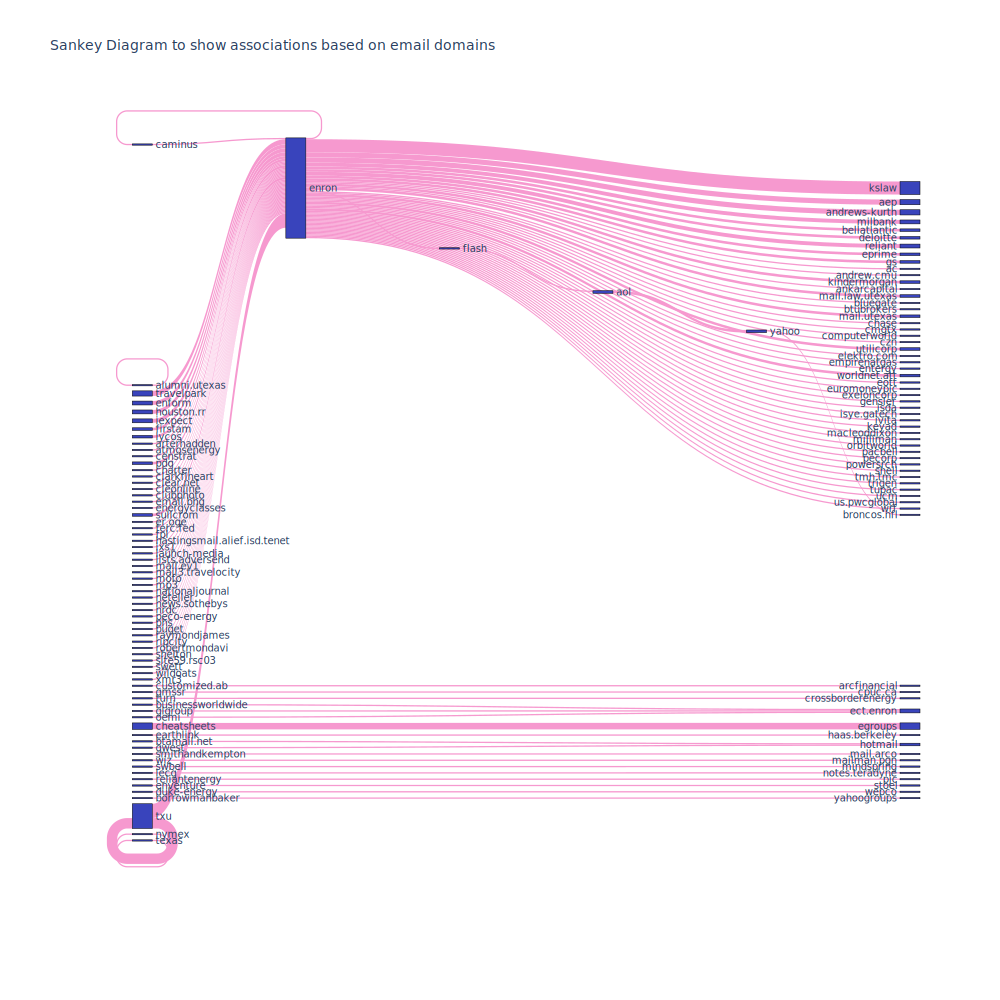

In [15]:
fig1 = go.Figure(data=[go.Sankey(
                    node = dict(
                        pad = 5, thickness = 20, line = dict(color = "black", width = 0.5),
                        label = full_list_of_domains, color = "#3944BC"
                    ),
                    link = dict(source = [s2[i] for i in sample_vals],
                                target = [d2[i] for i in sample_vals],
                                value = [v2[i] for i in sample_vals],
                                color = "#F699CF"))])

fig1.update_layout(title_text="Sankey Diagram to show associations based on email domains", font_size=10,
                  autosize=True, width=1000, height=1000)
    
fig1.show()


###   Knowledge graph

 We now try to discover associations / information from email messages by building the Knowledge Graph.

Building graphs requires nodes and edges; same goes for knowledge graphs. The nodes are going to be the entities mentioned in the sentences; edges are the relationships connecting the nodes. In this portion of the script, we also convert the email bodies into sentence tokens for us to extract the relations and the entity pairs.


**NOTE: plotting Knowledge Graph for email messages may not be quite feasible given the way that emails are written, the reason for doing Knowledge Graph for this exercise is purely for learning purposes**

**References:**
- https://gist.github.com/quadrismegistus/92a7fba479fc1e7d2661909d19d4ae7e, 
- https://pyvis.readthedocs.io/en/latest/tutorial.html, https://github.com/WestHealth/pyvis,
- https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

In [16]:
# - create the required "document"; we further create sentence tokens to extract the entities and relationships
email_doc_sentences = sent_tokenize(' '.join(emails_df_feat.body.to_list()))

We extract the entities and relations (if the entity pair does not contain just a 'blank' entity). This for loop takes a while, we use TQDM here to track its progress

In [17]:
entity_pairs = []
relations = []
exclusion_list = ['','you','i','me','them','we','they','it','this','who','us','he','that','she','what','>']
for i in tqdm(email_doc_sentences[:120]):
    if (get_entities(i)[0].lower() not in exclusion_list) and (get_entities(i)[1].lower() not in exclusion_list):
        entity_pairs.append(get_entities(i))
        relations.append(get_relation(i))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 31.79it/s]


We print the top 50 entity pairs and top 50 relations; choose one to plot for the Knowledge Graph later.

In [18]:
print(pd.Series(entity_pairs).value_counts().head(50))
print(pd.Series(relations).value_counts().head(50))

[Carlos Sole, Mitsubishi consent]                                  1
[National Energy Group, referenced Public Utilities Commission]    1
[first President Bush, successful SO2 trading program]             1
[temporary  Enron, suit]                                           1
[04/12/01 Britain, public bankruptcy case]                         1
[Federal  trustee, unsecured  utility]                             1
[spending package, immediate  state]                               1
[Customers, regulated Electric utility]                            1
[other National Energy that, same Electric Company]                1
[1965 Mustang GT proceeds, Hospital]                               1
[Neg, National Energy Group]                                       1
[already  who, sweaters]                                           1
[weather, great  60/70]                                            1
[apartment, right  office]                                         1
[bags, almost shopping trip]      

We now create the **dataframe for Knowledge Graph**. In the dataframe, we also include some colors and images for better visualization of the names of interest amongst the sea of nodes and edges. This part of the notebook is coded differently from that of the interactive visuals due to the use of different packages.

In [19]:
# - create the dataframe for Knowledge Graph
source_kg = [s[0] for s in entity_pairs]
destin_kg = [d[1] for d in entity_pairs]
know_df = pd.DataFrame({'source': source_kg, 'destination': destin_kg, 'edge': relations})

# - identify if the nodes contain names of interest (based on Wikipedia, the C-suite officers)
name_patterns = '[Ee]nron|[Bb]yron|[Kk]enneth|[Jj]effrey|[Ss]killing|[Aa]ndrew|[Ff]astow'

# - we create the filtered dataframe for Knowledge Graph based on name matching patterns
filtered_know_df = know_df.loc[(know_df.source.str.contains(name_patterns)) |
                               know_df.destination.str.contains(name_patterns), :].reset_index(drop=True)

sample_idx1 = random.sample(range(0, filtered_know_df.shape[0]), 4)  # we sample 120 entries
filtered_know_df = filtered_know_df.loc[sample_idx1, :].reset_index(drop=True)

# - create the nodes list with the colours; nodes are coloured if they contain the names of interest
full_nodes = filtered_know_df.source.to_list() + filtered_know_df.destination.to_list()
color_nodes = ['red' if re.findall(name_patterns, i.lower()) != [] else '#394DFF' for i in full_nodes]
image_nodes = ["/home/kelvinhwee/PycharmProjects/enronFraudEmailAnalysis/bad guy.JPG"
               if re.findall(name_patterns, i.lower()) != []
               else "/home/kelvinhwee/PycharmProjects/enronFraudEmailAnalysis/good guy.JPG" for i in full_nodes]

nodes_color_df = pd.DataFrame({'node': full_nodes, 'color': color_nodes, 'image': image_nodes})

Let's now **plot the knowledge graph**

In [82]:
# - plot the Knowledge Graph: initialise the networkx graph object
G_know = nx.Graph()

# - plot the Knowledge Graph: add nodes (do we want to consider the weightage)
for i in range(nodes_color_df.shape[0]):
    G_know.add_node(nodes_color_df["node"][i], color=nodes_color_df["color"][i],
                    shape='dot',
                    image=nodes_color_df["image"][i])

# - plot the Knowledge Graph: add edges (label the edges with the relation)
for i in range(filtered_know_df.shape[0]):
    G_know.add_edge(filtered_know_df["source"][i], filtered_know_df["destination"][i],
                    label=filtered_know_df["edge"][i], title=filtered_know_df["edge"][i])

# - we determine the colors for the nodes
G_know_node_color_list = pd.DataFrame([i for i in G_know]).rename({0:'node'}, axis = 1) \
                                    .merge(nodes_color_df, how = "left", on="node") \
                                    .drop_duplicates().loc[:,"color"].to_list()

# - plot the graph
plt.figure(figsize = (30,30))
pos1 = nx.spring_layout(G_know, k=.1)
nx.draw(G_know, pos1, node_size = 200, node_color = G_know_node_color_list, edge_color = 'grey', with_labels = True)
plt.show()

<Figure size 1440x1440 with 0 Axes>

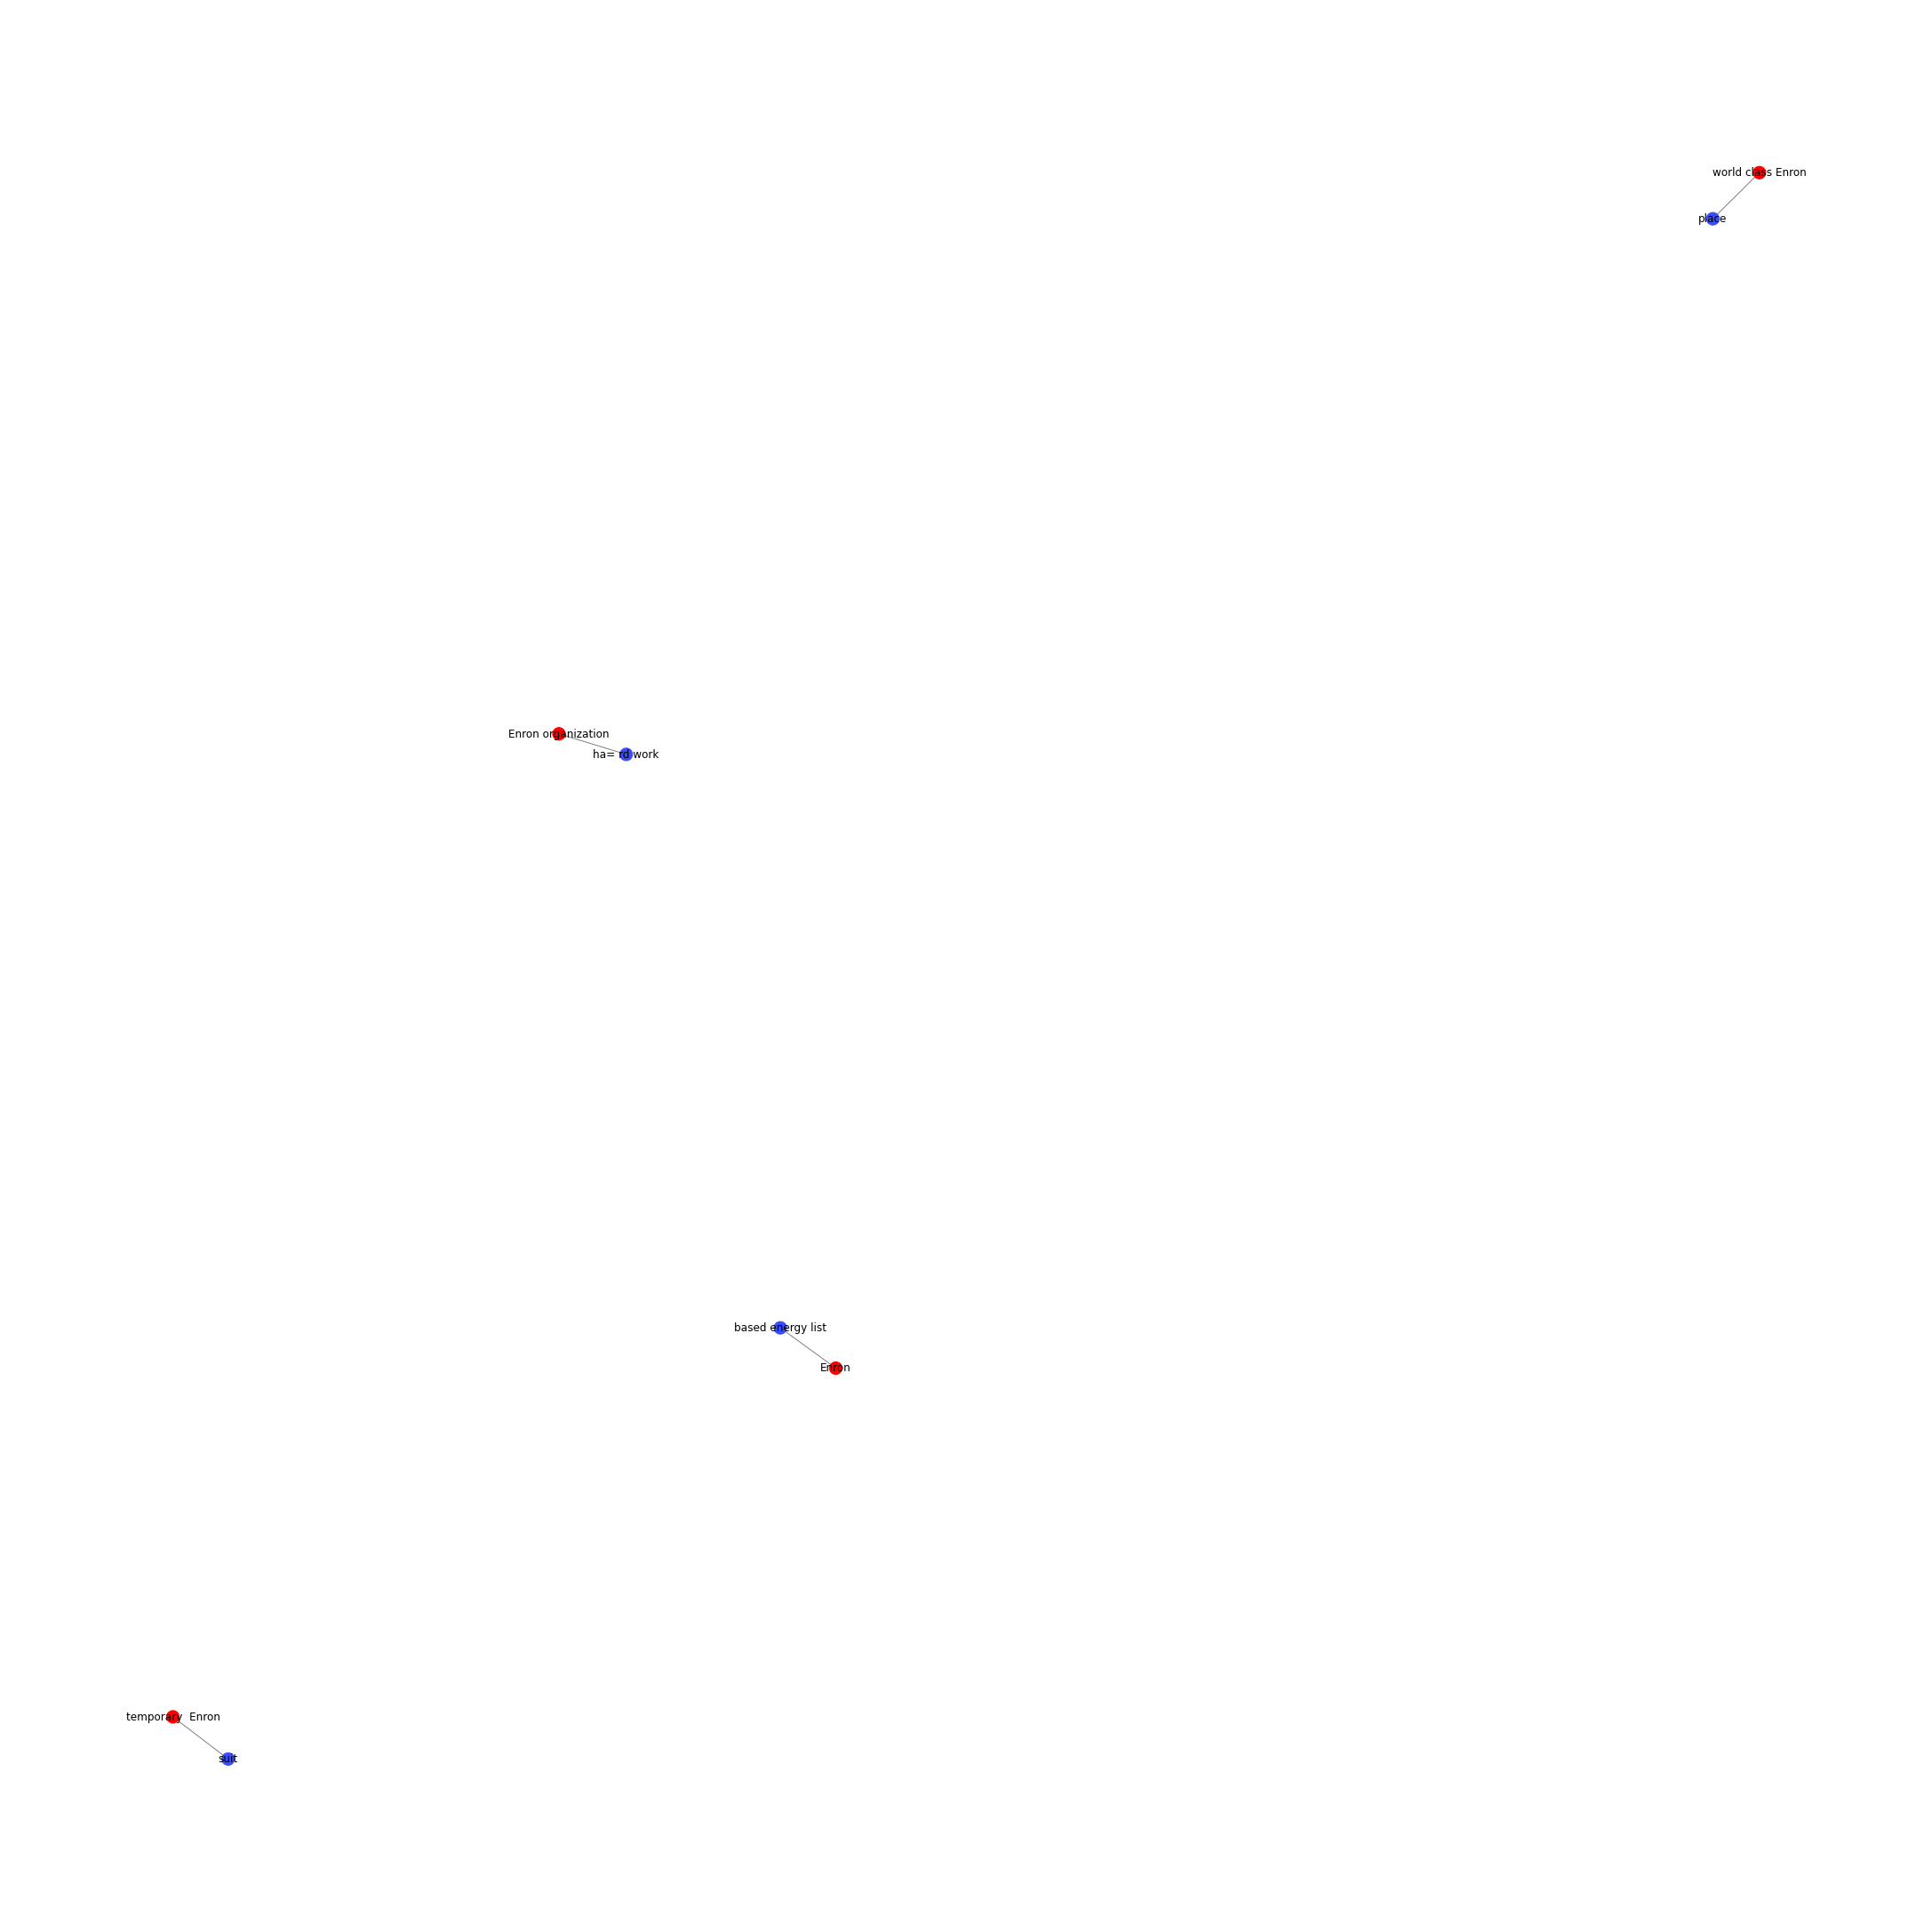

### Network graph 

We want to show the connections between various parties using network visualisations. Later on we will do some centrality scoring of parties and plot graph based on top three parties.

We now create the **dataframe for Network Graph**. In the dataframe, we also include some colors and images for better visualization of the names of interest amongst the sea of nodes and edges. This part of the notebook is coded differently from that of the interactive visuals due to the use of different packages.

In [69]:
# - get the one-to-one mapping for the email addresses
email_sender_list = emails_df_feat.From.to_list()
email_recipient_list = emails_df_feat.To.to_list()
net_source, net_destin, source_dest_net_map, _  = one_to_one_mapping(email_sender_list, email_recipient_list)

# - create the dataframe for Network Graph
net_df = pd.DataFrame({'source': net_source, 'destination': net_destin})

# - we create the filtered dataframe for Network Graph and drop 'blank' destinations and the self-sending ones
filtered_net_df = net_df.loc[net_df.destination != '', :].reset_index(drop = True)
filtered_net_df = filtered_net_df.loc[filtered_net_df.source != filtered_net_df.destination, :].reset_index(drop = True)

# - we identify which rows contain some of the names of interest (based on Wikipedia, the C-suite officers)
name_patterns_net = '[Ss]killing|[Ff]astow|[Jj]usbasche|[Cc]ooper|[Bb]elden'
interest_idx = filtered_net_df.loc[filtered_net_df.source.str.contains(name_patterns_net) |
                                   filtered_net_df.destination.str.contains(name_patterns_net), :].head(300).index

# - we identify names that we want to exclude
name_patterns_excl = '[Tt]echnology|outlook.team'
excl_idx = filtered_net_df.loc[filtered_net_df.source.str.contains(name_patterns_excl) |
                               filtered_net_df.destination.str.contains(name_patterns_excl), :].index

# - complete the list
list_of_idx = [num for num in range(filtered_net_df.shape[0]) if num not in list(excl_idx) + list(interest_idx)]

# - we take a sample of the dataframe for plotting the graph
sample_idx2 = random.sample(list_of_idx, min(500, len(list_of_idx))) + list(interest_idx) # sample the emails

# - final sample dataframe for plotting
sample_net_df = filtered_net_df.loc[sample_idx2 + list(interest_idx), :].reset_index(drop=True)

# - create the list of source and destination nodes
full_nodes_net = sample_net_df.source.to_list() + sample_net_df.destination.to_list()

# - we colour based on emails that contain names of interest, and whether the email address is an 'Enron' email
color_nodes_net = []
for i in full_nodes_net:
    if re.findall(name_patterns_net, i.lower()):
        color_nodes_net.append('red')
    elif 'enron' in i.lower():
        color_nodes_net.append('#AEF359')
    else:
        color_nodes_net.append('#394DFF')

nodes_color_net_df = pd.DataFrame({'node': full_nodes_net, 'color': color_nodes_net})


Let us now **plot the network graph.**.

In [70]:
# - plot the Network Graph: initialise the networkx graph object
G_net = nx.Graph()

# - plot the Network Graph: add nodes (do we want to consider the weightage)
for i in range(nodes_color_net_df.shape[0]):
    G_net.add_node(nodes_color_net_df["node"][i], color=nodes_color_net_df["color"][i], layout = 'hierarchical')

# - plot the Network Graph: add edges (label the edges with the relation)
for i in range(sample_net_df.shape[0]):
    G_net.add_edge(sample_net_df["source"][i], sample_net_df["destination"][i])

# - we determine the colors for the nodes
G_net_node_color_list = pd.DataFrame([i for i in G_net]).rename({0:'node'}, axis = 1) \
                                    .merge(nodes_color_net_df, how = "left", on="node") \
                                    .drop_duplicates().loc[:,"color"].to_list()

# - plot the graph
plt.figure(figsize = (30,30))
pos1 = nx.spring_layout(G_net, k=.1)
nx.draw(G_net, pos1, node_size = 200, node_color = G_net_node_color_list, edge_color = 'grey', with_labels = True)
plt.show()

### Centrality scoring of the nodes

We attempt to do the scoring based on three common centrality scoring methods:
- degree centrality
- closeness centrality
- betweenness centrality

**Degree centrality** is the most basic way of computing centrality. It simply measures the total number of connections linked to a node within a network graph. The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G.

In [86]:
# - we try to derive the degree centrality score of the nodes
deg_cent_G1 = nx.degree_centrality(G_net)
deg_g1_df = pd.DataFrame(deg_cent_G1.items(), columns=['Emails', 'Deg_centrality'])\
                            .sort_values(by = "Deg_centrality", ascending=False)

print('We look at the top 10 email addresses (for degree centrality): ', deg_g1_df.head(10))

We look at the top 10 email addresses (for degree centrality):                            Emails  Deg_centrality
234         tim.belden@enron.com        0.120643
677      jeff.skilling@enron.com        0.041555
18       rhonda.denton@enron.com        0.029491
8            jae.black@enron.com        0.029491
3        jeff.dasovich@enron.com        0.028150
4       cheryl.johnson@enron.com        0.021448
23       billy.lemmons@enron.com        0.016086
33   veronica.espinoza@enron.com        0.014745
51          tana.jones@enron.com        0.014745
0          scott.mills@enron.com        0.013405


**Closeness centrality** is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes.

In [87]:
# - we try to derive the closeness centrality score of the nodes
close_cent_G1 = nx.closeness_centrality(G_net)
close_g1_df = pd.DataFrame(close_cent_G1.items(), columns=['Emails', 'Closeness_centrality'])\
                            .sort_values(by = "Closeness_centrality", ascending=False)

print('We look at the top 10 email addresses (for closeness centrality): ', close_g1_df.head(10))

We look at the top 10 email addresses (for closeness centrality):                           Emails  Closeness_centrality
234        tim.belden@enron.com              0.182324
18      rhonda.denton@enron.com              0.153536
59   maureen.mcvicker@enron.com              0.149855
142           la.rose@enron.com              0.148130
128       simone.rose@enron.com              0.147431
193  leonardo.pacheco@enron.com              0.146838
104     james.steffes@enron.com              0.146347
3       jeff.dasovich@enron.com              0.144510
484      jeff.richter@enron.com              0.144510
67          mary.hain@enron.com              0.143374


**Betweenness centrality** is a way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another. The algorithm calculates unweighted shortest paths between all pairs of nodes in a graph.

In [88]:
# - we try to derive the between centrality score of the nodes
btwn_cent_G1 = nx.betweenness_centrality(G_net)
btwn_g1_df = pd.DataFrame(btwn_cent_G1.items(), columns=['Emails', 'Betweeness_centrality'])\
                            .sort_values(by = "Betweeness_centrality", ascending=False)

print('We look at the top 10 email addresses (for betweeness centrality): ', btwn_g1_df.head(10))

We look at the top 10 email addresses (for betweeness centrality):                          Emails  Betweeness_centrality
234       tim.belden@enron.com               0.243858
18     rhonda.denton@enron.com               0.085760
677    jeff.skilling@enron.com               0.064086
4     cheryl.johnson@enron.com               0.050395
484     jeff.richter@enron.com               0.040340
348   clayton.vernon@enron.com               0.035367
169     tamara.black@enron.com               0.034097
538  laura.podurgiel@enron.com               0.032819
8          jae.black@enron.com               0.032434
3      jeff.dasovich@enron.com               0.031583


Having done the above, we want to take a look based on all three measures of centrality, which are the top few email addresses that appear to be "most influential"

In [89]:
# - we combine the scores and return the top 3 and its graph
cent_scores_df = deg_g1_df.merge(close_g1_df, how='left', on='Emails').merge(btwn_g1_df, how='left', on='Emails')
cent_scores_df["Total_scores"] = cent_scores_df.Deg_centrality * \
                                 cent_scores_df.Closeness_centrality * \
                                 cent_scores_df.Betweeness_centrality

cent_scores_df = cent_scores_df.sort_values(by="Total_scores", ascending=False)

print('We look at the top 10 email addresses (for total score): ', cent_scores_df.head(10))

We look at the top 10 email addresses (for total score):                           Emails  Deg_centrality  Closeness_centrality  \
0          tim.belden@enron.com        0.120643              0.182324   
2       rhonda.denton@enron.com        0.029491              0.153536   
1       jeff.skilling@enron.com        0.041555              0.127499   
5      cheryl.johnson@enron.com        0.021448              0.124241   
4       jeff.dasovich@enron.com        0.028150              0.144510   
3           jae.black@enron.com        0.029491              0.077011   
6       billy.lemmons@enron.com        0.016086              0.115516   
14   maureen.mcvicker@enron.com        0.010724              0.149855   
8          tana.jones@enron.com        0.014745              0.088185   
7   veronica.espinoza@enron.com        0.014745              0.112314   

    Betweeness_centrality  Total_scores  
0                0.243858      0.005364  
2                0.085760      0.000388  
1           

We now create the dataframe for Network Graph for the **most influential nodes**. In the dataframe, we also include some colors and images for better visualization of the names of interest amongst the sea of nodes and edges.

In [90]:
# - plot graph for the top 3 most central nodes
top3_emails = cent_scores_df.loc[:2, "Emails"].to_list()

top3_net_df = filtered_net_df.loc[filtered_net_df.source.isin(top3_emails) |
                                  filtered_net_df.destination.isin(top3_emails), :].reset_index(drop=True)

# - create the list of source and destination nodes
top3_nodes_net = top3_net_df.source.to_list() + top3_net_df.destination.to_list()

# - we colour based on emails that contain names of interest, and whether the email address is an 'Enron' email
top3_color_nodes_net = []
for i in top3_nodes_net:
    if i in top3_emails:
        top3_color_nodes_net.append('red')
    elif 'enron' in i.lower():
        top3_color_nodes_net.append('#AEF359')
    else:
        top3_color_nodes_net.append('#3944BC')

top3_nodes_color_net_df = pd.DataFrame({'node': top3_nodes_net, 'color': top3_color_nodes_net})

Let us now plot the network graph for the **most influential nodes.**

In [ ]:
# - plot the Network Graph: initialise the networkx graph object
G_net_top3 = nx.Graph()

# - plot the Network Graph: add nodes (do we want to consider the weightage)
for i in range(top3_nodes_color_net_df.shape[0]):
    G_net_top3.add_node(top3_nodes_color_net_df["node"][i],
                        color=top3_nodes_color_net_df["color"][i],
                        layout = 'hierarchical')

# - plot the Network Graph: add edges (label the edges with the relation)
for i in range(top3_net_df.shape[0]):
    G_net_top3.add_edge(top3_net_df["source"][i], top3_net_df["destination"][i])

# - we determine the colors for the nodes
G_net_node_color_top3_list = pd.DataFrame([i for i in G_net_top3]).rename({0:'node'}, axis = 1) \
                                    .merge(top3_nodes_color_net_df, how = "left", on="node") \
                                    .drop_duplicates().loc[:,"color"].to_list()

# - plot the graph
plt.figure(figsize = (30,30))
pos1 = nx.spring_layout(G_net_top3, k=.1)
nx.draw(G_net_top3, pos1, node_size = 200, node_color = G_net_node_color_top3_list,
        edge_color = 'grey', with_labels = True)

plt.show()
    
    
# # - plot the final graph using Pyvis (https://pyvis.readthedocs.io/en/latest/documentation.html)
# top3_network = Network(height=1000, width=1200, directed=True)
# top3_network.toggle_hide_edges_on_drag(False)
# top3_network.from_nx(G_net_top3)
# top3_network.show("network_graph_top3.html")

**Some final notes**
We have tried to look for connections / relations / associations within the dataset using three main ways:
- using just email domain to see which other companies Enron employees correspond with; or if there is any correspondence between Enron employees with private emails (domains such as hotmail, yahoo), we can also see the relations
- using email message texts, we could see some of the associations between the entity pairs. For this exercise, we mentioned that Knowledge Graphs may not be the best way to represent the text data given the way how email messages are written, mostly speaking in first-person view rather than third-person views
- using network graphs, we saw the overall relationship between email addresses and we could see that some nodes are more influential than the others

Through the above exercise, we can pick out the most influential nodes, and work our way through them as a starting point, from the point of investigations.